In [1]:
"""
Autohr: Sergi Mas Pujol
Last update: 24/11/2020

Python version: 3.6
"""

'\nAutohr: Sergi Mas Pujol\nLast update: 24/11/2020\n\nPython version: 3.6\n'

In [1]:
import numpy as np
np.random.seed(4)
import sys
import math
import random
random.seed(7)
from random import sample
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

from utils_samplesTraining import read_REGULATIONS_file
from utils_timeProcessing import from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots, \
                                 substract_minutes_given_HHSSMM, add_minutes_given_HHSSMM, \
                                 from_YYYYMMDD_to_DDMMYYYY_given_separator, \
                                 listDays_betweenTwoDates, \
                                 from_YYYYMMDDHHMMSS_to_HHMMSS
from utils_samplesTraining import readAssociatedFile_fromAIRAC_givenDate, \
                                  extract_regulations,\
                                  addIntervals_toFinalConjunt
from generator import extract_days_timestamps_volumes_labels_days_with_regulations, \
                      extract_features_from_list_days_and_timestamps

from generator_weather import extract_weather_information_from_list_days_and_timestamps

In [2]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Using TensorFlow backend.
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [3]:
# sectorName = 'BOLN'
# sectorName = 'D6WH'
# sectorName = 'B3EH'

sectorName = 'HRHR'
# sectorName = 'HSOL'
# sectorName = 'B3LL'

# MASD3WLC

In [4]:
# Given the start timestamp of the regulation -> Considered time before and after
# Temporal gaps in minutes
gap_before_start_time = 0
gap_after_start_time = 30

In [5]:
num_epochs = 200
batch_size = 32

# Used to extract more samples from a particular sector
if sectorName == 'BOLN':
    num_additional_samples_per_day = 25
else:
    num_additional_samples_per_day = 50

In [6]:
# num_weather_features = 7
num_weather_features = 16

num_metric_per_weather_feature = 3

# Prepare / Extreact data

###  Extract the available regulations

In [8]:
REGULATIONS = read_REGULATIONS_file('./20190604_20191020_REGULATIONS.csv')

"""
If the regulation contains a cancel_time -> It will be ignored
    * To take them into account -> Remove last condition
"""
# REGULATIONS_from_given_sector = REGULATIONS.loc[(REGULATIONS["traffic_volume"] == ' MAS'+sectorName+' ') &
#                                                 (REGULATIONS["regulation_reason"].isin([' C-ATC Capacity ', ' R-ATC Routeing '])) & 
#                                                 (REGULATIONS["location_type"] == ' En route ') &
#                                                 (REGULATIONS["cancel_time"] == '  ')
#                                                ] 

REGULATIONS_from_given_sector = REGULATIONS.loc[(REGULATIONS["traffic_volume"] == ' MAS'+sectorName+' ') &
                                                (REGULATIONS["regulation_reason"].isin([' W-Weather '])) & 
                                                (REGULATIONS["location_type"] == ' En route ') &
                                                (REGULATIONS["cancel_time"] == '  ')
                                               ]



In [9]:
# ".strip() -> Remove all the white spaaces in the timestamp"

REGULATIONS_from_given_sector.loc[:, 'date_DDMMYYYY'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDD_to_DDMMYYYY_given_separator(x.target_date.strip(), '/'), axis=1)

REGULATIONS_from_given_sector.loc[:, 'start_time_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.start_time.strip()), axis=1)
REGULATIONS_from_given_sector.loc[:, 'end_time_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.end_time.strip()), axis=1)
REGULATIONS_from_given_sector.loc[:, 'start_time_study_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: substract_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_before_start_time), axis=1)
REGULATIONS_from_given_sector.loc[:, 'end_time_study_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: add_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_after_start_time), axis=1)

/home/sergi/.local/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/sergi/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# We want to remove from the DataFrame all the rows outside the valid interval of days
# Outside the date of the available AIRACS
min_date = date(2019, 6, 4)
# max_date = date(2019, 8, 14) 
max_date = date(2019, 9, 11) 


for index, row in REGULATIONS_from_given_sector.iterrows():
        
    date_split = row["date_DDMMYYYY"].split("/") # 0 -> day; 1 -> month; 2 -> year
    date_object = date(int(date_split[2]), int(date_split[1]), int(date_split[0]))
    
    # Check if the regulation's date belong to the valid interval -> IF outside, drop the Regulation
    if date_object < min_date or date_object > max_date:
        REGULATIONS_from_given_sector = REGULATIONS_from_given_sector.drop(index=index)

In [11]:
print('Number regulations AFTER pre-processing: ', str(len(REGULATIONS_from_given_sector.values)))

Number regulations AFTER pre-processing:  15


### Extract the different list of days and timestamps

##### Samples without regulations from days without regulations

In [12]:
# Extract the days with regulations
list_days_with_regulations = REGULATIONS_from_given_sector["date_DDMMYYYY"].values

# Initialize a list with all the possible days and the final list for the days without regulations
list_all_possible_days = listDays_betweenTwoDates(min_date, max_date, 'DDMMYYYY', '/')
list_days_without_regulations = list()

In [13]:
# If a day does not appear in the list with reguilations -> No regulations for that day
for day in list_all_possible_days:
    if day not in list_days_with_regulations:
        list_days_without_regulations.append(day)

In [14]:
# For the days without regulations, we will generate random timestamps

list_days_without_regulations_extended = list()
start_time_samples_no_regulations = list()
end_time_samples_no_regulations = list()

for day in list_days_without_regulations:
    # Iterate multiple time each day without regulations
    for _ in range(0,1):
        # Randomly create the hour and the minutes
        hour = str("{:02d}".format(random.randint(3,21))) # From 2 to 22 to avoid extrems (wrap around timestamps)
        minute = str("{:02d}".format(random.randint(0,50)))

        # Create the timestamp
        random_timestamps = hour + ":" + minute + ":" + '00'

        # Append the day of the timestamp
        list_days_without_regulations_extended.append(day)
        
        # Substract a given about to create the starting timestamp
        start_timestamp = substract_minutes_given_HHSSMM(random_timestamps, gap_before_start_time)
        start_time_samples_no_regulations.append(start_timestamp)

        # Add a given about to create the ending timestamp
        end_timestamp = add_minutes_given_HHSSMM(random_timestamps, gap_after_start_time)
        end_time_samples_no_regulations.append(end_timestamp)

In [15]:
len(list_days_without_regulations_extended), len(start_time_samples_no_regulations), len(end_time_samples_no_regulations)

(88, 88, 88)

##### Sample with & without regulations from days with regulations completly random 
##### It is possible ta have sample with both categories (e.g. start NO Regs from Regs and then Reg)

In [16]:
REGULATIONS_from_given_sector.loc[:, 'start_regulations_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.start_time.strip()), axis=1)
REGULATIONS_from_given_sector.loc[:, 'end_regulations_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.end_time.strip()), axis=1)

In [17]:
list_dates_with_regulations = REGULATIONS_from_given_sector["date_DDMMYYYY"].values

start_regulations = REGULATIONS_from_given_sector["start_regulations_HHMMSS"].values
end_regulations = REGULATIONS_from_given_sector["end_regulations_HHMMSS"].values

list_volumes_regulations = REGULATIONS_from_given_sector["traffic_volume"].values

In [18]:
list_days_from_regulations, \
start_time_samples_days_from_regulations, \
end_time_samples_days_from_regulations, \
volumes_days_from_regulations, \
labels_days_from_regulations = extract_days_timestamps_volumes_labels_days_with_regulations(list_dates_with_regulations, 
                                                                      start_regulations,
                                                                      end_regulations,
                                                                      list_volumes_regulations, 
                                                                      gap_before_start_time, 
                                                                      gap_after_start_time, 
                                                                      num_additional_samples_per_day=num_additional_samples_per_day,
                                                                      min_timestamps_with_regulations=10)

In [19]:
len(list_days_from_regulations), len(start_time_samples_days_from_regulations), \
len(end_time_samples_days_from_regulations), len(volumes_days_from_regulations)

(255, 255, 255, 255)

# Extract all the features for the given dates and timestamps

In [20]:
list_days_without_regulations_extended = np.array(list_days_without_regulations_extended)
start_time_samples_no_regulations = np.array(start_time_samples_no_regulations)
end_time_samples_no_regulations = np.array(end_time_samples_no_regulations)

In [21]:
X_days_without_regulations = np.zeros((len(list_days_without_regulations_extended), 
                                       int(gap_before_start_time+gap_after_start_time), 
                                       11))
X_days_without_regulations.shape

(88, 30, 11)

In [22]:
X_days_without_regulations = extract_features_from_list_days_and_timestamps(list_days_without_regulations_extended, 
                                                                           start_time_samples_no_regulations, 
                                                                           end_time_samples_no_regulations,
                                                                           sectorName,
                                                                           gap_before_start_time, gap_after_start_time,
                                                                           X_days_without_regulations)

HRHR | counter: 1
HRHR | counter: 2
HRHR | counter: 3
HRHR | counter: 4
HRHR | counter: 5
HRHR | counter: 6
HRHR | counter: 7
HRHR | counter: 8
HRHR | counter: 9
HRHR | counter: 10
HRHR | counter: 11
HRHR | counter: 12
HRHR | counter: 13
HRHR | counter: 14
HRHR | counter: 15
HRHR | counter: 16
HRHR | counter: 17
HRHR | counter: 18
HRHR | counter: 19
HRHR | counter: 20
HRHR | counter: 21
HRHR | counter: 22
HRHR | counter: 23
HRHR | counter: 24
HRHR | counter: 25
HRHR | counter: 26
HRHR | counter: 27
HRHR | counter: 28
HRHR | counter: 29
HRHR | counter: 30
HRHR | counter: 31
HRHR | counter: 32
HRHR | counter: 33
HRHR | counter: 34
HRHR | counter: 35
HRHR | counter: 36
HRHR | counter: 37
HRHR | counter: 38
HRHR | counter: 39
HRHR | counter: 40
HRHR | counter: 41
HRHR | counter: 42
HRHR | counter: 43
HRHR | counter: 44
HRHR | counter: 45
HRHR | counter: 46
HRHR | counter: 47
HRHR | counter: 48
HRHR | counter: 49
HRHR | counter: 50
HRHR | counter: 51
HRHR | counter: 52
HRHR | counter: 53
HR

In [23]:
np.save('./Counting_variables/Weather/X_days_without_regulations', X_days_without_regulations)

In [24]:
list_days_from_regulations = np.array(list_days_from_regulations)
start_time_samples_days_from_regulations = np.array(start_time_samples_days_from_regulations)
end_time_samples_days_from_regulations = np.array(end_time_samples_days_from_regulations)

In [25]:
X_days_from_regulations = np.zeros((len(list_days_from_regulations), 
                                    int(gap_before_start_time+gap_after_start_time), 
                                    11))
X_days_from_regulations.shape

(255, 30, 11)

In [26]:
X_days_from_regulations = extract_features_from_list_days_and_timestamps(list_days_from_regulations, 
                                                                       start_time_samples_days_from_regulations, 
                                                                       end_time_samples_days_from_regulations,
                                                                       sectorName,
                                                                       gap_before_start_time, gap_after_start_time,
                                                                       X_days_from_regulations)

HRHR | counter: 1
HRHR | counter: 2
HRHR | counter: 3
HRHR | counter: 4
HRHR | counter: 5
HRHR | counter: 6
HRHR | counter: 7
HRHR | counter: 8
HRHR | counter: 9
HRHR | counter: 10
HRHR | counter: 11
HRHR | counter: 12
HRHR | counter: 13
HRHR | counter: 14
HRHR | counter: 15
HRHR | counter: 16
HRHR | counter: 17
HRHR | counter: 18
HRHR | counter: 19
HRHR | counter: 20
HRHR | counter: 21
HRHR | counter: 22
HRHR | counter: 23
HRHR | counter: 24
HRHR | counter: 25
HRHR | counter: 26
HRHR | counter: 27
HRHR | counter: 28
HRHR | counter: 29
HRHR | counter: 30
HRHR | counter: 31
HRHR | counter: 32
HRHR | counter: 33
HRHR | counter: 34
HRHR | counter: 35
HRHR | counter: 36
HRHR | counter: 37
HRHR | counter: 38
HRHR | counter: 39
HRHR | counter: 40
HRHR | counter: 41
HRHR | counter: 42
HRHR | counter: 43
HRHR | counter: 44
HRHR | counter: 45
HRHR | counter: 46
HRHR | counter: 47
HRHR | counter: 48
HRHR | counter: 49
HRHR | counter: 50
HRHR | counter: 51
HRHR | counter: 52
HRHR | counter: 53
HR

In [27]:
np.save('./Counting_variables/Weather/X_days_from_regulations', X_days_from_regulations)
np.save('./Counting_variables/Weather/labels_days_from_regulations', labels_days_from_regulations)

# Extract the weather features 

In [29]:
X_days_without_regulations_weather = np.zeros((len(list_days_without_regulations_extended), 
                                            int(gap_before_start_time+gap_after_start_time), 
                                            num_weather_features*num_metric_per_weather_feature))
X_days_without_regulations_weather.shape

(88, 30, 21)

In [30]:
X_days_without_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_without_regulations_extended, 
    start_time_samples_no_regulations, 
    end_time_samples_no_regulations,
    sectorName,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_without_regulations_weather)

day: 04/06/2019 | start:130900 | TV: HRHR
day: 05/06/2019 | start:154100 | TV: HRHR
day: 06/06/2019 | start:040400 | TV: HRHR
day: 08/06/2019 | start:200600 | TV: HRHR
day: 09/06/2019 | start:143700 | TV: HRHR
day: 10/06/2019 | start:043200 | TV: HRHR
day: 11/06/2019 | start:090200 | TV: HRHR
day: 13/06/2019 | start:052700 | TV: HRHR
day: 14/06/2019 | start:160400 | TV: HRHR
day: 16/06/2019 | start:100500 | TV: HRHR
day: 17/06/2019 | start:202700 | TV: HRHR
day: 18/06/2019 | start:043600 | TV: HRHR
day: 20/06/2019 | start:061400 | TV: HRHR
day: 21/06/2019 | start:210300 | TV: HRHR
day: 22/06/2019 | start:213700 | TV: HRHR
day: 23/06/2019 | start:150300 | TV: HRHR
day: 24/06/2019 | start:100200 | TV: HRHR
day: 25/06/2019 | start:200800 | TV: HRHR
day: 26/06/2019 | start:122600 | TV: HRHR
day: 27/06/2019 | start:073400 | TV: HRHR
day: 28/06/2019 | start:063600 | TV: HRHR
day: 29/06/2019 | start:123500 | TV: HRHR
day: 30/06/2019 | start:080600 | TV: HRHR
day: 01/07/2019 | start:213600 | T

In [31]:
np.save('./Counting_variables/Weather/X_days_without_regulations_weather', X_days_without_regulations_weather)

In [32]:
X_days_from_regulations_weather = np.zeros((len(list_days_from_regulations), 
                                            int(gap_before_start_time+gap_after_start_time), 
                                            num_weather_features*num_metric_per_weather_feature))
X_days_from_regulations_weather.shape

(255, 30, 21)

In [33]:
X_days_from_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_from_regulations, 
    start_time_samples_days_from_regulations, 
    end_time_samples_days_from_regulations,
    sectorName,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_from_regulations_weather)

day: 07/06/2019 | start:141100 | TV: HRHR
day: 07/06/2019 | start:034000 | TV: HRHR
day: 07/06/2019 | start:094000 | TV: HRHR
day: 07/06/2019 | start:165000 | TV: HRHR
day: 07/06/2019 | start:073700 | TV: HRHR
day: 07/06/2019 | start:161800 | TV: HRHR
day: 07/06/2019 | start:043200 | TV: HRHR
day: 12/06/2019 | start:113800 | TV: HRHR
day: 12/06/2019 | start:114500 | TV: HRHR
day: 12/06/2019 | start:063500 | TV: HRHR
day: 12/06/2019 | start:124200 | TV: HRHR
day: 12/06/2019 | start:051700 | TV: HRHR
day: 12/06/2019 | start:111200 | TV: HRHR
day: 12/06/2019 | start:131500 | TV: HRHR
day: 12/06/2019 | start:111300 | TV: HRHR
day: 12/06/2019 | start:083700 | TV: HRHR
day: 12/06/2019 | start:111100 | TV: HRHR
day: 12/06/2019 | start:203600 | TV: HRHR
day: 12/06/2019 | start:114900 | TV: HRHR
day: 12/06/2019 | start:101700 | TV: HRHR
day: 12/06/2019 | start:111300 | TV: HRHR
day: 12/06/2019 | start:082200 | TV: HRHR
day: 12/06/2019 | start:124300 | TV: HRHR
day: 15/06/2019 | start:092800 | T

day: 09/08/2019 | start:094000 | TV: HRHR
day: 09/08/2019 | start:191100 | TV: HRHR
day: 09/08/2019 | start:144300 | TV: HRHR
day: 09/08/2019 | start:172300 | TV: HRHR
day: 26/08/2019 | start:151300 | TV: HRHR
day: 26/08/2019 | start:144700 | TV: HRHR
day: 26/08/2019 | start:154300 | TV: HRHR
day: 26/08/2019 | start:163900 | TV: HRHR
day: 26/08/2019 | start:141900 | TV: HRHR
day: 26/08/2019 | start:084900 | TV: HRHR
day: 26/08/2019 | start:145000 | TV: HRHR
day: 26/08/2019 | start:131600 | TV: HRHR
day: 27/08/2019 | start:165000 | TV: HRHR
day: 27/08/2019 | start:162600 | TV: HRHR
day: 27/08/2019 | start:153100 | TV: HRHR
day: 27/08/2019 | start:192700 | TV: HRHR
day: 27/08/2019 | start:184800 | TV: HRHR
day: 27/08/2019 | start:044200 | TV: HRHR
day: 27/08/2019 | start:154900 | TV: HRHR
day: 27/08/2019 | start:175000 | TV: HRHR
day: 27/08/2019 | start:033300 | TV: HRHR
day: 27/08/2019 | start:214700 | TV: HRHR
day: 27/08/2019 | start:164600 | TV: HRHR
day: 27/08/2019 | start:153800 | T

In [34]:
np.save('./Counting_variables/Weather/X_days_from_regulations_weather', X_days_from_regulations_weather)

# Concatenate the scalar variables and the weather features

In [7]:
X_days_without_regulations = np.load('./Counting_variables/Weather/X_days_without_regulations.npy')
X_days_without_regulations_weather = np.load('./Counting_variables/Weather/X_days_without_regulations_weather.npy')

X_days_from_regulations = np.load('./Counting_variables/Weather/X_days_from_regulations.npy')
X_days_from_regulations_weather = np.load('./Counting_variables/Weather/X_days_from_regulations_weather.npy')

labels_days_from_regulations = np.load('./Counting_variables/Weather/labels_days_from_regulations.npy')

In [8]:
X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
                                                   X_days_without_regulations.shape[1],
                                                   X_days_without_regulations.shape[2]+X_days_without_regulations_weather.shape[2]))

X_days_without_regulations_concatenate.shape

# X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
#                                                    X_days_without_regulations.shape[1],
#                                                    X_days_without_regulations.shape[2]))

# X_days_without_regulations_concatenate.shape

(88, 30, 59)

In [9]:
X_days_without_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_without_regulations_weather
X_days_without_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_without_regulations

# X_days_without_regulations_concatenate = X_days_without_regulations


In [10]:
# np.save('./Counting_variables/Weather/X_days_without_regulations_concatenate', X_days_without_regulations_concatenate)

In [11]:
X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
                                                X_days_from_regulations.shape[1],
                                                X_days_from_regulations.shape[2]+X_days_from_regulations_weather.shape[2]))

X_days_from_regulations_concatenate.shape

# X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
#                                                 X_days_from_regulations.shape[1],
#                                                 X_days_from_regulations.shape[2]))

# X_days_from_regulations_concatenate.shape

(387, 30, 59)

In [12]:
X_days_from_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_from_regulations_weather
X_days_from_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_from_regulations

# X_days_from_regulations_concatenate = X_days_from_regulations

In [13]:
# np.save('./Counting_variables/Weather/X_days_from_regulations_concatenate', X_days_from_regulations_concatenate)

# Create the labels

In [14]:
Y_days_without_regulations = np.zeros((X_days_without_regulations.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [15]:
Y_days_without_regulations.shape

(88, 30, 1)

In [16]:
Y_from_regulations = np.zeros((X_days_from_regulations.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [17]:
Y_from_regulations = labels_days_from_regulations

In [18]:
Y_from_regulations.shape

(387, 30, 1)

# Split into training & testing - By day

In [19]:
X_days_without_regulations_concatenate.shape, Y_days_without_regulations.shape

((88, 30, 59), (88, 30, 1))

In [20]:
X_days_from_regulations_concatenate.shape, Y_from_regulations.shape

((387, 30, 59), (387, 30, 1))

In [21]:
num_train_samples_days_without_regulations = int(np.floor(X_days_without_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_without_regulations

61

In [22]:
num_train_samples_days_from_regulations = int(np.floor(X_days_from_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_from_regulations

270

In [23]:
X_train = np.concatenate((X_days_without_regulations_concatenate[0:num_train_samples_days_without_regulations],
                          X_days_from_regulations_concatenate[0:num_train_samples_days_from_regulations]))

y_train = np.concatenate((Y_days_without_regulations[0:num_train_samples_days_without_regulations],
                          Y_from_regulations[0:num_train_samples_days_from_regulations]))

In [24]:
X_train.shape, y_train.shape

((331, 30, 59), (331, 30, 1))

In [25]:
X_test = np.concatenate((X_days_without_regulations_concatenate[num_train_samples_days_without_regulations:],
                         X_days_from_regulations_concatenate[num_train_samples_days_from_regulations:]))

y_test = np.concatenate((Y_days_without_regulations[num_train_samples_days_without_regulations:],
                         Y_from_regulations[num_train_samples_days_from_regulations:]))

In [26]:
X_test.shape, y_test.shape

((144, 30, 59), (144, 30, 1))

In [27]:
# np.save('./Counting_variables/Weather/X_train', X_train)
# np.save('./Counting_variables/Weather/y_train', y_train)
# np.save('./Counting_variables/Weather/X_test', X_test)
# np.save('./Counting_variables/Weather/y_test', y_test)

# Only using the max values form the weather features

In [28]:
X_train.shape

(331, 30, 59)

In [29]:
list_weather_features_delete = []
for i in range(num_weather_features):
    list_weather_features_delete.append(0+i*num_metric_per_weather_feature)
    list_weather_features_delete.append(1+i*num_metric_per_weather_feature)

In [31]:
list_weather_features_delete,len(list_weather_features_delete)

([0, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 19], 14)

In [32]:
X_train_del = np.zeros((X_train.shape[0], X_train.shape[1], 18))
X_test_del = np.zeros((X_test.shape[0], X_test.shape[1], 18))

for j in range(X_train.shape[0]):
    X_train_del[j] = np.delete(X_train[j], list_weather_features_delete, axis=1)
for j in range(X_test.shape[0]):
    X_test_del[j] = np.delete(X_test[j], list_weather_features_delete, axis=1)


In [33]:
X_train_del.shape, X_test_del.shape

((239, 30, 18), (104, 30, 18))

In [34]:
# Used it to avoid having to change the name of the variables in the following lines
X_train = X_train_del
X_test = X_test_del

# Using StandardScaler from sklearn.preprocessing - OLD

In [35]:
# # Fit and store a scaler for each channel

# scalers = {}
# for i in range(X_train.shape[1]):
#     scalers[i] = StandardScaler()
#     X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

# for i in range(X_test.shape[1]):
#     X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])

# Apply PCA - OLD

In [36]:
# X_train.shape

In [37]:
# n_components=32

# X_train_pca = np.zeros((X_train.shape[0], X_train.shape[1], n_components))
# X_test_pca = np.zeros((X_test.shape[0], X_test.shape[1], n_components))

# pca = {}
# for i in range(X_train.shape[1]):
#     pca[i] = PCA(n_components=n_components)
#     X_train_pca[:, i, :] = pca[i].fit_transform(X_train[:, i, :]) 

# # scalers = {}
# for i in range(X_test.shape[1]):
# #     scalers[i] = StandardScaler()
#     X_test_pca[:, i, :] = pca[i].fit_transform(X_test[:, i, :])

In [38]:
# X_train_pca.shape, X_test_pca.shape

In [39]:
# X_train = X_train_pca
# X_test = X_test_pca

In [40]:
# for i in range(X_train.shape[1]):
#     c = [np.random.random_sample(), np.random.random_sample(), np.random.random_sample()]
#     plt.plot(np.cumsum(pca[i].explained_variance_ratio_), color=c)
    
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')

# Convert multiple timesteps to independent samples

In [30]:
X_train.shape, X_test.shape

((331, 30, 59), (144, 30, 59))

In [34]:
X_train_simpleClassifier = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 59))
X_test_simpleClassifier = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 59))

# X_train_simpleClassifier = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 18))
# X_test_simpleClassifier = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 18))

# X_train_simpleClassifier = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 16))
# X_test_simpleClassifier = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 16))

In [35]:
X_train_simpleClassifier.shape, X_test_simpleClassifier.shape

((9930, 59), (4320, 59))

In [36]:
y_train.shape, y_test.shape

((331, 30, 1), (144, 30, 1))

In [37]:
y_train_simpleClassifier = np.reshape(y_train, (y_train.shape[0]*y_train.shape[1], 1))
y_test_simpleClassifier = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], 1))

In [38]:
y_train_simpleClassifier.shape, y_test_simpleClassifier.shape

((9930, 1), (4320, 1))

# Using StandardScaler from sklearn.preprocessing

In [47]:
scaler = StandardScaler()
scaler.fit(X_train_simpleClassifier)
X_sc_train = scaler.transform(X_train_simpleClassifier)
X_sc_test = scaler.transform(X_test_simpleClassifier)

# PCA

In [60]:
pca = PCA(n_components=14)

X_pca_train = pca.fit_transform(X_train_simpleClassifier)
X_pca_test = pca.transform(X_test_simpleClassifier)

X_sc_pca_train = pca.fit_transform(X_sc_train)
X_sc_pca_test = pca.transform(X_sc_test)

In [61]:
X_pca_train.shape, X_pca_test.shape

((7170, 14), (3120, 14))

Text(0, 0.5, 'Cumulative explained variance')

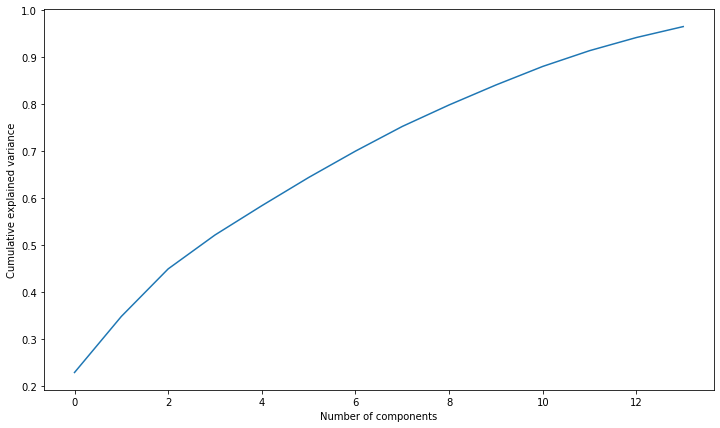

In [62]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

# Train the model

In [39]:
from keras.layers import BatchNormalization
from keras.models import Sequential

In [52]:
def classifier():
    
    classifier = Sequential()
    classifier.add(Dense(59, activation='relu', input_dim=59))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(28, activation='sigmoid'))
    classifier.add(Dropout(0.5))
#     classifier.add(Dense(28, activation='sigmoid'))
#     classifier.add(Dropout(0.5))
    classifier.add(Dense(7, activation='sigmoid'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(1, activation='sigmoid'))

    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    return classifier

In [53]:
# def classifier():

#     classifier = Sequential()
#     classifier.add(Dense(32, activation='relu', input_dim=32))
#     classifier.add(BatchNormalization())
#     classifier.add(Dropout(0.5))
#     classifier.add(Dense(2, activation='softmax'))

#     classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
#     return classifier

In [54]:
model = classifier()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 59)                3540      
_________________________________________________________________
dropout_9 (Dropout)          (None, 59)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 28)                1680      
_________________________________________________________________
dropout_10 (Dropout)         (None, 28)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 7)                 203       
_________________________________________________________________
dropout_11 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [55]:
# from utils_samplesTraining import convert_to_one_hot

# y_train_simpleClassifier_oh = convert_to_one_hot(y_train, c = 2) 
# y_test_simpleClassifier_oh = convert_to_one_hot(y_test, c = 2) 

In [56]:
history = model.fit(X_train_simpleClassifier, y_train_simpleClassifier, 
                    validation_data = (X_test_simpleClassifier, y_test_simpleClassifier),
                    epochs = 200, batch_size = 250, shuffle=True)

# history = model.fit(X_sc_train, y_train_simpleClassifier, 
#                     validation_data = (X_sc_test, y_test_simpleClassifier),
#                     epochs = 200, batch_size = 250, shuffle=True)

# history = model.fit(X_pca_train, y_train_simpleClassifier, 
#                     validation_data = (X_pca_test, y_test_simpleClassifier),
#                     epochs = 200, batch_size = 250, shuffle=True)

# history = model.fit(X_sc_pca_train, y_train_simpleClassifier, 
#                     validation_data = (X_sc_pca_test, y_test_simpleClassifier),
#                     epochs = 200, batch_size = 250, shuffle=True)

# history = model.fit(X_train_simpleClassifier, y_train_simpleClassifier_oh, 
#                     validation_data = (X_test_simpleClassifier, y_test_simpleClassifier_oh),
#                     epochs = 200, batch_size = 250, shuffle=True)

Train on 9930 samples, validate on 4320 samples
Epoch 1/200
9930/9930 [==============================] - 0s 32us/step - loss: 0.7683 - accuracy: 0.5002 - val_loss: 0.7122 - val_accuracy: 0.4773
Epoch 2/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.7480 - accuracy: 0.4965 - val_loss: 0.6995 - val_accuracy: 0.4773
Epoch 3/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.7304 - accuracy: 0.5043 - val_loss: 0.7052 - val_accuracy: 0.4773
Epoch 4/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.7174 - accuracy: 0.5013 - val_loss: 0.7013 - val_accuracy: 0.4773
Epoch 5/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.7128 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.4773
Epoch 6/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.7057 - accuracy: 0.5017 - val_loss: 0.6959 - val_accuracy: 0.4773
Epoch 7/200
9930/9930 [==============================] - 0s 10us/step - loss

9930/9930 [==============================] - 0s 11us/step - loss: 0.6926 - accuracy: 0.5199 - val_loss: 0.6957 - val_accuracy: 0.4773
Epoch 57/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.6929 - accuracy: 0.5162 - val_loss: 0.6958 - val_accuracy: 0.4773
Epoch 58/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6926 - accuracy: 0.5158 - val_loss: 0.6958 - val_accuracy: 0.4773
Epoch 59/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6928 - accuracy: 0.5175 - val_loss: 0.6957 - val_accuracy: 0.4773
Epoch 60/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6927 - accuracy: 0.5166 - val_loss: 0.6958 - val_accuracy: 0.4773
Epoch 61/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6927 - accuracy: 0.5165 - val_loss: 0.6958 - val_accuracy: 0.4773
Epoch 62/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6926 - accuracy: 0.5166 - val_loss: 0.6958 - val_a

Epoch 112/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.6928 - accuracy: 0.5179 - val_loss: 0.6957 - val_accuracy: 0.4773
Epoch 113/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.6924 - accuracy: 0.5199 - val_loss: 0.6957 - val_accuracy: 0.4773
Epoch 114/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.6926 - accuracy: 0.5177 - val_loss: 0.6957 - val_accuracy: 0.4773
Epoch 115/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6925 - accuracy: 0.5186 - val_loss: 0.6956 - val_accuracy: 0.4773
Epoch 116/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6926 - accuracy: 0.5175 - val_loss: 0.6956 - val_accuracy: 0.4773
Epoch 117/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6926 - accuracy: 0.5181 - val_loss: 0.6956 - val_accuracy: 0.4773
Epoch 118/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6923 - accuracy: 0.5191 - val_

9930/9930 [==============================] - 0s 10us/step - loss: 0.6923 - accuracy: 0.5197 - val_loss: 0.6955 - val_accuracy: 0.4773
Epoch 168/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6925 - accuracy: 0.5188 - val_loss: 0.6956 - val_accuracy: 0.4773
Epoch 169/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.6925 - accuracy: 0.5188 - val_loss: 0.6956 - val_accuracy: 0.4773
Epoch 170/200
9930/9930 [==============================] - 0s 11us/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6955 - val_accuracy: 0.4773
Epoch 171/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6926 - accuracy: 0.5181 - val_loss: 0.6956 - val_accuracy: 0.4773
Epoch 172/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6927 - accuracy: 0.5173 - val_loss: 0.6956 - val_accuracy: 0.4773
Epoch 173/200
9930/9930 [==============================] - 0s 10us/step - loss: 0.6925 - accuracy: 0.5195 - val_loss: 0.6956 -

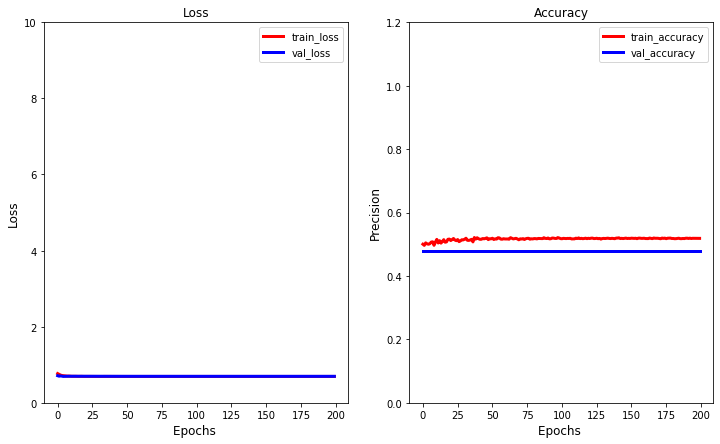

In [57]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], 'r', linewidth=3.0) 
axs[0].plot(history.history['val_loss'], 'b', linewidth=3.0)
axs[0].legend(['train_loss', 'val_loss'], fontsize=10)
axs[0].set_xlabel('Epochs ', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].set_ylim(0,10)
axs[0].set_title('Loss', fontsize=12)

axs[1].plot(history.history['accuracy'], 'r', linewidth=3.0) 
axs[1].plot(history.history['val_accuracy'], 'b', linewidth=3.0)
axs[1].legend(['train_accuracy', 'val_accuracy'], fontsize=10)
axs[1].set_xlabel('Epochs ', fontsize=12)
axs[1].set_ylabel('Precision', fontsize=12) 
axs[1].set_ylim(0,1.2)
axs[1].set_title('Accuracy', fontsize=12)
plt.show()

# Evaluate the model

In [58]:
from metrics import confusion_matrix

### Training samples

In [59]:
TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
                                               X_train_simpleClassifier, 
                                               y_train_simpleClassifier)

# TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
#                                                X_sc_train, 
#                                                y_train_simpleClassifier)

# TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
#                                                X_sc_pca_train, 
#                                                y_train_simpleClassifier)

# TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
#                                                X_sc_pca_train, 
#                                                y_train_simpleClassifier)


# TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
#                                                X_train_simpleClassifier, 
#                                                y_train_simpleClassifier_oh)

In [60]:
conf_matrix

array([[5151., 4779.],
       [   0.,    0.]])

In [120]:
print("Accuracy training: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall training: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion training: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy training: 94.20%
Recall training: 89.61%
Precicion training: 97.90%


### Testing samples

In [121]:
# TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
#                                                X_test_simpleClassifier, 
#                                                y_test_simpleClassifier)

# TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
#                                                X_sc_test, 
#                                                y_test_simpleClassifier)

# TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
#                                                X_pca_test, 
#                                                y_test_simpleClassifier)

TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
                                               X_sc_pca_test, 
                                               y_test_simpleClassifier)

# TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
#                                                X_test_simpleClassifier, 
#                                                y_test_simpleClassifier_oh)

In [122]:
conf_matrix

array([[ 689.,   38.],
       [ 712., 1681.]])

In [123]:
print("Accuracy testing: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall testing: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion testing: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy testing: 75.96%
Recall testing: 49.18%
Precicion testing: 94.77%


In [144]:
sys.exit()

SystemExit: 

/home/sergi/anaconda3/envs/PhD_GPU/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Analysing similaritis

In [ ]:
from metrics import similarity_sequential_output_percentage_correct

In [ ]:
equal, similar, incorrect = similarity_sequential_output_percentage_correct(model, X_test, y_test, 90)

In [ ]:
equal, similar, incorrect

# From many-to-many to many-to-one

In [ ]:
from metrics import detect_regulations_binary, updated_detect_regulations_binary

In [ ]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = detect_regulations_binary(model, X_test, y_test)

In [ ]:
conf_matrix_binary

In [ ]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")

In [ ]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = updated_detect_regulations_binary(model, 
                                                                                                   X_test, 
                                                                                                   y_test, 
                                                                                                   1)

In [ ]:
conf_matrix_binary

In [ ]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")